## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, regular_type, output_units=10, num_neurons=[512, 256, 128], ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=regular_type(ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regular_type(ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio in EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], ratio=regulizer_ratio, regular_type=l1)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
196/196 [==============================] - 6s 29ms/step - loss: 199.0

Epoch 50/50
196/196 [==============================] - 5s 27ms/step - loss: 2.6395 - accuracy: 0.6289 - val_loss: 2.8992 - val_accuracy: 0.5267
Experiment with Regulizer = 0.000000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
__

Epoch 49/50
196/196 [==============================] - 5s 27ms/step - loss: 0.8844 - accuracy: 0.6898 - val_loss: 1.3592 - val_accuracy: 0.5392
Epoch 50/50
196/196 [==============================] - 5s 27ms/step - loss: 0.8765 - accuracy: 0.6940 - val_loss: 1.4489 - val_accuracy: 0.5150


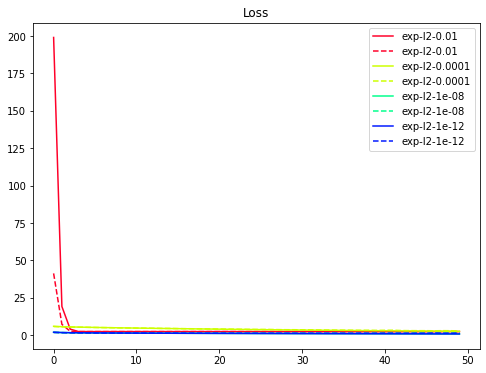

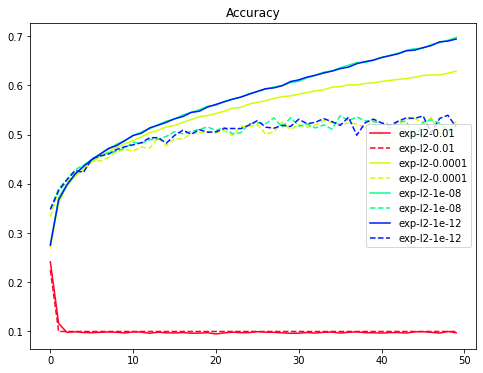

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio in EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], ratio=regulizer_ratio, regular_type=l2)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
196/196 [==============================] - 5s 26ms/step - loss: 15.09

Epoch 50/50
196/196 [==============================] - 5s 26ms/step - loss: 1.0474 - accuracy: 0.6812 - val_loss: 1.5091 - val_accuracy: 0.5349
Experiment with Regulizer = 0.000000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
__

Epoch 49/50
196/196 [==============================] - 5s 26ms/step - loss: 0.8864 - accuracy: 0.6864 - val_loss: 1.4655 - val_accuracy: 0.5209
Epoch 50/50
196/196 [==============================] - 5s 26ms/step - loss: 0.8695 - accuracy: 0.6957 - val_loss: 1.4103 - val_accuracy: 0.5342


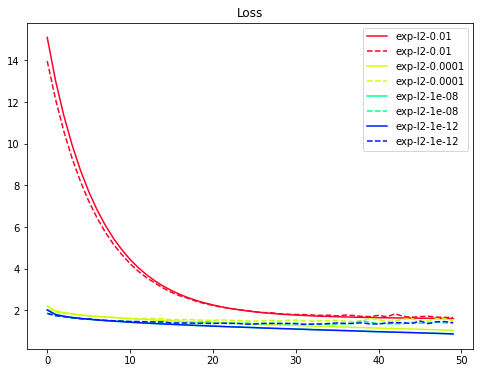

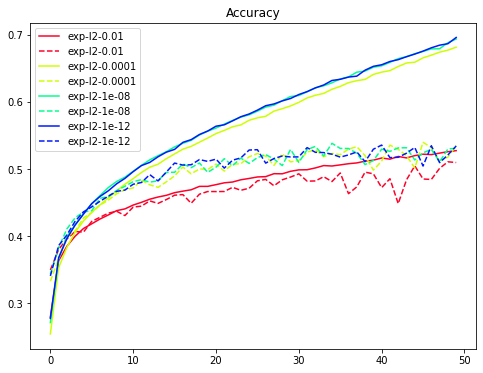

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [11]:
def build_mlp_mix(input_shape, regular_type, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=regular_type(l1_ratio,l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regular_type(l1_ratio,l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [12]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
EXP = [1e-4, 1e-8, 1e-12]

In [13]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio_i in EXP:
    for regulizer_ratio_j in EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer L1 = %.6f, Regulizer L2 = %.6f" % (regulizer_ratio_i,regulizer_ratio_j))
        model = build_mlp_mix(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio_i, l2_ratio=regulizer_ratio_j, regular_type=l1_l2)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "exp-11-%s-12-%s" % (str(regulizer_ratio_i),str(regulizer_ratio_j))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with Regulizer L1 = 0.000100, Regulizer L2 = 0.000100
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
196/196 [==============================] 

196/196 [==============================] - 6s 33ms/step - loss: 2.6665 - accuracy: 0.6293 - val_loss: 3.0514 - val_accuracy: 0.4958
Epoch 50/50
196/196 [==============================] - 6s 33ms/step - loss: 2.6356 - accuracy: 0.6316 - val_loss: 2.9589 - val_accuracy: 0.5147
Experiment with Regulizer L1 = 0.000100, Regulizer L2 = 0.000000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
__________________________________________________

196/196 [==============================] - 6s 33ms/step - loss: 1.0561 - accuracy: 0.6786 - val_loss: 1.5046 - val_accuracy: 0.5368
Epoch 48/50
196/196 [==============================] - 6s 32ms/step - loss: 1.0489 - accuracy: 0.6806 - val_loss: 1.6278 - val_accuracy: 0.4989
Epoch 49/50
196/196 [==============================] - 6s 33ms/step - loss: 1.0346 - accuracy: 0.6880 - val_loss: 1.5471 - val_accuracy: 0.5267
Epoch 50/50
196/196 [==============================] - 7s 37ms/step - loss: 1.0218 - accuracy: 0.6917 - val_loss: 1.7438 - val_accuracy: 0.4942
Experiment with Regulizer L1 = 0.000000, Regulizer L2 = 0.000000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
__________________________

196/196 [==============================] - 7s 34ms/step - loss: 0.9474 - accuracy: 0.6672 - val_loss: 1.3743 - val_accuracy: 0.5383
Epoch 46/50
196/196 [==============================] - 7s 34ms/step - loss: 0.9336 - accuracy: 0.6716 - val_loss: 1.4996 - val_accuracy: 0.5082
Epoch 47/50
196/196 [==============================] - 7s 34ms/step - loss: 0.9247 - accuracy: 0.6744 - val_loss: 1.3986 - val_accuracy: 0.5295
Epoch 48/50
196/196 [==============================] - 7s 35ms/step - loss: 0.9059 - accuracy: 0.6819 - val_loss: 1.4008 - val_accuracy: 0.5320
Epoch 49/50
196/196 [==============================] - 7s 35ms/step - loss: 0.8998 - accuracy: 0.6844 - val_loss: 1.3988 - val_accuracy: 0.5326
Epoch 50/50
196/196 [==============================] - 7s 35ms/step - loss: 0.8875 - accuracy: 0.6880 - val_loss: 1.3957 - val_accuracy: 0.5327
Experiment with Regulizer L1 = 0.000000, Regulizer L2 = 0.000100
Model: "model"
_________________________________________________________________
La

196/196 [==============================] - 7s 33ms/step - loss: 0.9612 - accuracy: 0.6628 - val_loss: 1.3756 - val_accuracy: 0.5301
Epoch 44/50
196/196 [==============================] - 6s 32ms/step - loss: 0.9475 - accuracy: 0.6670 - val_loss: 1.4301 - val_accuracy: 0.5144
Epoch 45/50
196/196 [==============================] - 6s 32ms/step - loss: 0.9361 - accuracy: 0.6716 - val_loss: 1.4076 - val_accuracy: 0.5234
Epoch 46/50
196/196 [==============================] - 6s 33ms/step - loss: 0.9174 - accuracy: 0.6767 - val_loss: 1.4047 - val_accuracy: 0.5226
Epoch 47/50
196/196 [==============================] - 6s 33ms/step - loss: 0.9058 - accuracy: 0.6812 - val_loss: 1.3662 - val_accuracy: 0.5373
Epoch 48/50
196/196 [==============================] - 7s 36ms/step - loss: 0.8932 - accuracy: 0.6883 - val_loss: 1.3934 - val_accuracy: 0.5279
Epoch 49/50
196/196 [==============================] - 7s 35ms/step - loss: 0.8821 - accuracy: 0.6905 - val_loss: 1.3749 - val_accuracy: 0.5338
Epoc

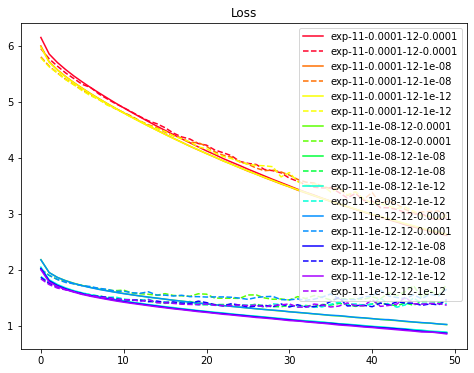

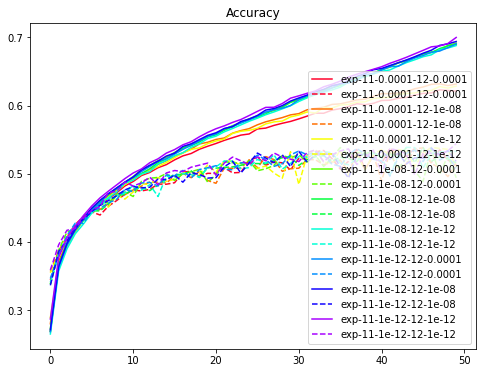

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [ ]:
'''
以此筆資料集之結果來看，
訓練集: 當L1回歸比例設為1e-12時，最高為0.6940
驗證集: 當L1回歸比例設為1e-4時，最高為0.5267

訓練集: 當L2回歸比例設為1e-12時，最高為0.6957
驗證集: 當L2回歸比例設為1e-4時，最高為0.5349

訓練集: 同時使用L1、L2回歸比例設為1e-12、1e-12時，最高為0.6999
驗證集: 同時使用L1、L2回歸比例設為1e-12、1e-12時，最高為0.5441

總結來看同時使用L1、L2回歸較單獨使用結果來的好。
'''